<a href="https://colab.research.google.com/github/paulrolland1602/IAE_METZ_2026_EMPIRICAL_FINANCLE/blob/main/SCRIPTS/devoir_python_Yannis_Paul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Réallocation Sectorielle face au Choc de Taux 2025

## Quel est l’impact d’un maintien des taux restrictifs sur l’arbitrage rendement-risque et la diversification sectorielle ?


In [ ]:
import yfinance as yf
print('Notebook fonctionnel !')

Notebook fonctionnel !


### 1. Importation et Configuration des Bibliothèques

In [ ]:
# 1. Bibliothèques de base
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Ajouts
from scipy.stats import norm  # Pour les calculs de VaR et stats
import datetime as dt         # Pour gérer les périodes fév/juin 2025 proprement
from scipy.optimize import minimize # Pour trouver précisément le portefeuille optimal

# Configuration du style graphique
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="ticks")
%matplotlib inline

### 2. Chargement des Données et Définition des Périodes d'Étude

#### Explication de la section :

Cette section est cruciale pour préparer les données financières nécessaires à notre analyse. Nous utilisons la bibliothèque `yfinance` pour télécharger les prix de clôture historiques des ETF sectoriels (définis par `TICKERS`). Pour étudier l'impact du 'choc de taux' de 2025, nous définissons une `DATE_CHOC` et découpons les rendements journaliers en deux périodes distinctes : une période 'Avant Choc' (représentant l'anticipation du marché) et une période 'Après Choc' (représentant la réaction au choc réel).

In [ ]:
# Date centrale : Le pivot de la FED
DATE_CHOC = '2025-03-15'

# Calcul des bornes (4 mois de chaque côté)
DEBUT_AVANT = '2024-11-15' # 4 mois avant
FIN_APRES   = '2025-07-15' # 4 mois après

# 1) Téléchargement avec une marge de sécurité pour l'historique
data = yf.download(TICKERS, start='2024-06-01', end=FIN_APRES)['Close']
rets = data.pct_change().dropna()

# 2) Découpage des DataFrames
R_avant = rets.loc[DEBUT_AVANT:DATE_CHOC]
R_apres = rets.loc[DATE_CHOC:FIN_APRES]

print(f"Période AVANT : du {DEBUT_AVANT} au {DATE_CHOC} ({len(R_avant)} jours)")
print(f"Période APRÈS : du {DATE_CHOC} au {FIN_APRES} ({len(R_apres)} jours)")

/tmp/ipython-input-2396376505.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS, start='2024-06-01', end=FIN_APRES)['Close']
[*********************100%***********************]  7 of 7 completed

Période AVANT : du 2024-11-15 au 2025-03-15 (80 jours)
Période APRÈS : du 2025-03-15 au 2025-07-15 (82 jours)


### 3. Calcul des Paramètres Statistiques Annualisés

#### Explication de la section :

Pour modéliser le comportement des portefeuilles, il est essentiel de calculer les paramètres statistiques clés : les rendements moyens (`mu`) et les matrices de covariance (`cov`). Ces valeurs sont annualisées (multipliées par 252 jours de bourse) pour refléter une perspective annuelle, ce qui est standard en finance. Un taux sans risque (`rf`) est également défini, essentiel pour le calcul du Ratio de Sharpe.

In [ ]:
# On définit le facteur d'annualisation (252 jours de bourse)
ANN = 252

# 1. Période AVANT (Anticipation)
mu_avant = R_avant.mean() * ANN
cov_avant = R_avant.cov() * ANN

# 2. Période APRÈS (Choc FED)
mu_apres = R_apres.mean() * ANN
cov_apres = R_apres.cov() * ANN

# 3. Définition du Taux Sans Risque (Risk-Free Rate)
# Pour 2025, on peut prendre 4.5% (0.045) car la FED ne baisse pas les taux
rf = 0.045

print("Statistiques calculées et annualisées.")
print(f"Rendement moyen Tech (XLK) Avant: {mu_avant['XLK']:.2%}")
print(f"Rendement moyen Tech (XLK) Après: {mu_apres['XLK']:.2%}")

Statistiques calculées et annualisées.
Rendement moyen Tech (XLK) Avant: -25.34%
Rendement moyen Tech (XLK) Après: 62.39%


### 4. Simulation Monte Carlo de Portefeuilles

#### Explication de la section :

La méthode de Monte Carlo est employée ici pour simuler des milliers de portefeuilles possibles. Pour chaque portefeuille, des poids d'actifs aléatoires sont générés. Ensuite, le rendement, la volatilité et le Ratio de Sharpe de ce portefeuille sont calculés à partir des rendements moyens et de la matrice de covariance de la période correspondante. Cette simulation nous permet de visualiser un large éventail de combinaisons risque-rendement.

In [ ]:
def simulation_mc(mu, cov, rf, n_sims=10000):
    n_assets = len(mu)
    # On stocke : [Rendement, Volatilité, Sharpe, Poids...]
    results = np.zeros((3 + n_assets, n_sims))

    for i in range(n_sims):
        # 1. Générer des poids aléatoires dont la somme fait 1 (100%)
        w = np.random.random(n_assets)
        w /= np.sum(w)

        # 2. Calcul du rendement et du risque du portefeuille
        p_ret = np.sum(mu * w)
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w)))

        # 3. Calcul du Sharpe Ratio
        p_sharpe = (p_ret - rf) / p_std

        # 4. Stockage
        results[0,i] = p_ret
        results[1,i] = p_std
        results[2,i] = p_sharpe
        results[3:,i] = w

    # On transforme en DataFrame pour que ce soit facile à manipuler
    cols = ['Ret', 'Vol', 'Sharpe'] + list(mu.index)
    return pd.DataFrame(results.T, columns=cols)

# Exécution pour les deux périodes
df_avant = simulation_mc(mu_avant, cov_avant, rf)
df_apres = simulation_mc(mu_apres, cov_apres, rf)

print("Simulations terminées !")
print(f"Meilleur Sharpe AVANT : {df_avant['Sharpe'].max():.2f}")
print(f"Meilleur Sharpe APRÈS : {df_apres['Sharpe'].max():.2f}")

Simulations terminées !
Meilleur Sharpe AVANT : -0.30
Meilleur Sharpe APRÈS : 1.88


### 5. Visualisation des Frontières Efficientes

#### Explication de la section :

Cette section présente graphiquement les résultats de la simulation Monte Carlo. Chaque point sur le graphique représente un portefeuille simulé, avec sa volatilité (risque) sur l'axe des abscisses et son rendement sur l'axe des ordonnées. La couleur des points indique le Ratio de Sharpe. Les étoiles marquent les portefeuilles optimaux qui maximisent le Ratio de Sharpe pour chaque période, mettant en évidence le déplacement de la frontière efficiente avant et après le choc.

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-821551843.py:22: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Volatilité Annualisée ($\sigma$)', fontsize=12)


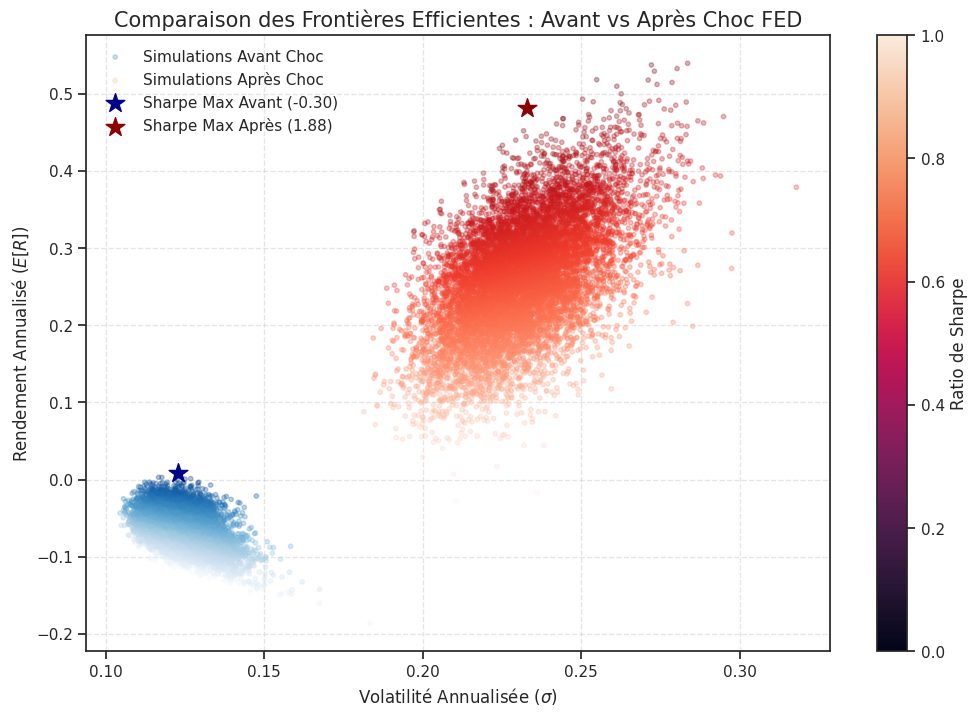

In [ ]:
plt.figure(figsize=(12, 8))

# Nuage de points AVANT (Bleu)
plt.scatter(df_avant['Vol'], df_avant['Ret'], c=df_avant['Sharpe'], cmap='Blues',
            s=10, alpha=0.3, label='Simulations Avant Choc')

# Nuage de points APRÈS (Rouge)
plt.scatter(df_apres['Vol'], df_apres['Ret'], c=df_apres['Sharpe'], cmap='Reds',
            s=10, alpha=0.3, label='Simulations Après Choc')

# Extraction des portefeuilles optimaux (Sharpe Max)
best_avant = df_avant.iloc[df_avant['Sharpe'].idxmax()]
best_apres = df_apres.iloc[df_apres['Sharpe'].idxmax()]

# Marquer les points optimaux
plt.scatter(best_avant['Vol'], best_avant['Ret'], color='darkblue', marker='*',
            s=200, label=f'Sharpe Max Avant ({best_avant["Sharpe"]:.2f})')
plt.scatter(best_apres['Vol'], best_apres['Ret'], color='darkred', marker='*',
            s=200, label=f'Sharpe Max Après ({best_apres["Sharpe"]:.2f})')

plt.title('Comparaison des Frontières Efficientes : Avant vs Après Choc FED', fontsize=15)
plt.xlabel('Volatilité Annualisée ($\sigma$)', fontsize=12)
plt.ylabel('Rendement Annualisé ($E[R]$)', fontsize=12)
plt.colorbar(label='Ratio de Sharpe')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### 6. Analyse de la Mutation de l'Allocation Optimale

#### Explication de la section :

Ce graphique compare les pondérations des actifs dans les portefeuilles optimaux (ceux avec le Ratio de Sharpe maximal) avant et après le choc de taux. Il permet de visualiser comment l'allocation stratégique des capitaux entre les différents secteurs devrait changer en réponse à la nouvelle réalité des marchés. On peut ainsi identifier les secteurs devenus plus ou moins attractifs.

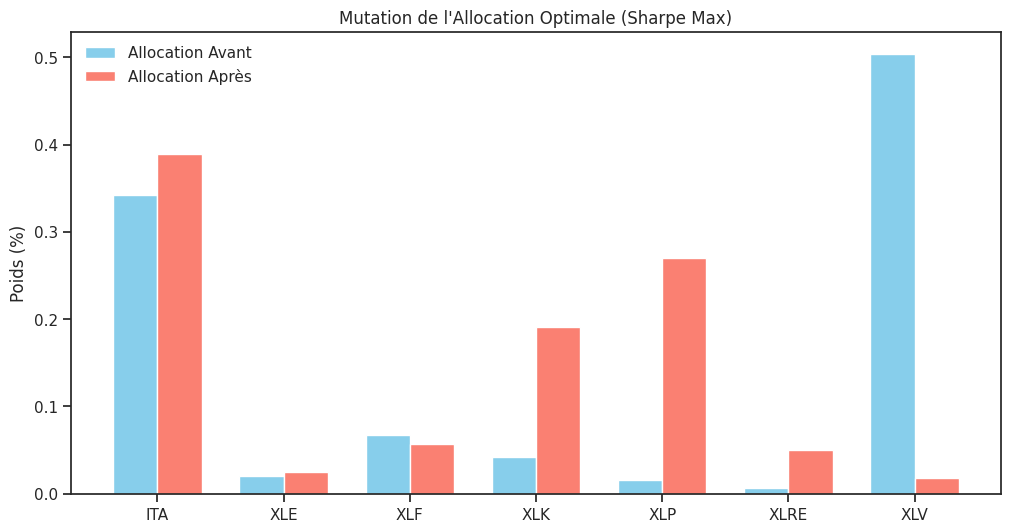

In [ ]:
# Extraction des poids uniquement
w_avant = best_avant[list(mu_avant.index)]
w_apres = best_apres[list(mu_apres.index)]

# Création du graphique
plt.figure(figsize=(12, 6))
x = np.arange(len(w_avant))
width = 0.35

plt.bar(x - width/2, w_avant, width, label='Allocation Avant', color='skyblue')
plt.bar(x + width/2, w_apres, width, label='Allocation Après', color='salmon')

plt.xticks(x, w_avant.index)
plt.ylabel('Poids (%)')
plt.title('Mutation de l\'Allocation Optimale (Sharpe Max)')
plt.legend()
plt.show()

### 7. Analyse des Corrélations Inter-Secteurs

#### Explication de la section :

Les matrices de corrélation mesurent la tendance des rendements des différents secteurs à évoluer ensemble. Une corrélation élevée signifie que les secteurs ont tendance à monter ou descendre en même temps, réduisant les avantages de la diversification. En comparant les matrices avant et après le choc, nous pouvons observer l'impact du changement de régime de taux sur la diversification du portefeuille.

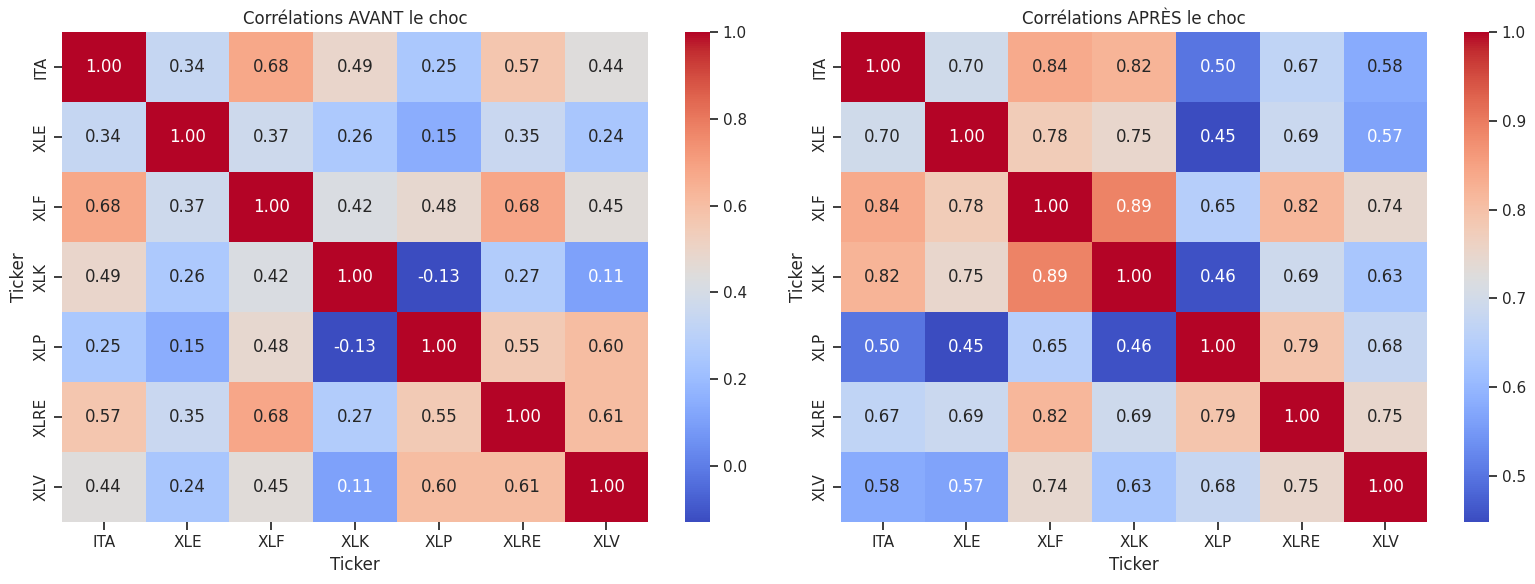

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Corrélation Avant
sns.heatmap(R_avant.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax1)
ax1.set_title('Corrélations AVANT le choc')

# Corrélation Après
sns.heatmap(R_apres.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax2)
ax2.set_title('Corrélations APRÈS le choc')

plt.tight_layout()
plt.show()

### 8. Contribution au Risque du Portefeuille (Après Choc)

#### Explication de la section :
Il est important non seulement de connaître les poids des actifs dans un portefeuille, mais aussi leur contribution réelle au risque total du portefeuille. Cette section compare les pondérations des actifs avec leur part dans le risque global du portefeuille optimal post-choc. Cela révèle si certains actifs, bien que peu pondérés, apportent une part disproportionnée du risque.

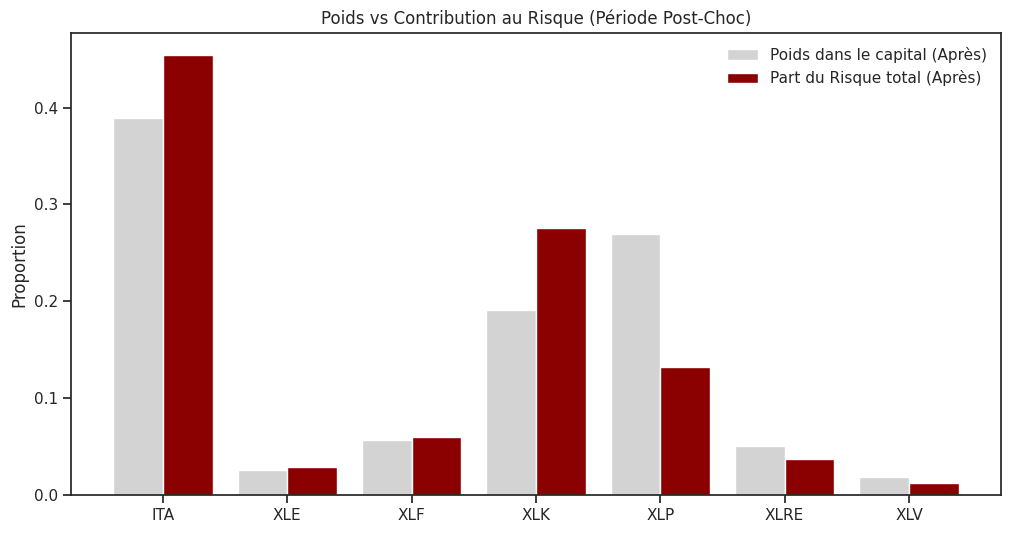

In [ ]:
def risk_contribution(weights, cov_matrix):
    # Volatilité totale du portefeuille
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Contribution marginale de chaque actif
    marginal_contrib = np.dot(cov_matrix, weights) / portfolio_vol
    # Contribution réelle (poids * contribution marginale)
    component_contrib = weights * marginal_contrib
    return component_contrib / portfolio_vol # Normalisé à 100%

# Calcul pour les deux portefeuilles optimaux
rc_avant = risk_contribution(best_avant[list(mu_avant.index)].values, cov_avant)
rc_apres = risk_contribution(best_apres[list(mu_apres.index)].values, cov_apres)

# Plot de comparaison
labels = list(mu_avant.index)
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, best_apres[labels], 0.4, label='Poids dans le capital (Après)', color='lightgrey')
plt.bar(x + 0.2, rc_apres, 0.4, label='Part du Risque total (Après)', color='darkred')

plt.xticks(x, labels)
plt.ylabel('Proportion')
plt.title('Poids vs Contribution au Risque (Période Post-Choc)')
plt.legend()
plt.show()

### 9. Comparaison de la Structure du Risque (Avant vs Après Choc)

#### Explication de la section :

Cette analyse étend la compréhension de la contribution au risque en comparant la structure du risque avant et après le choc de taux. Elle met en évidence comment la contribution relative des différents secteurs au risque total du portefeuille optimal a évolué, offrant des insights sur la résilience et la sensibilité des secteurs aux changements macroéconomiques.

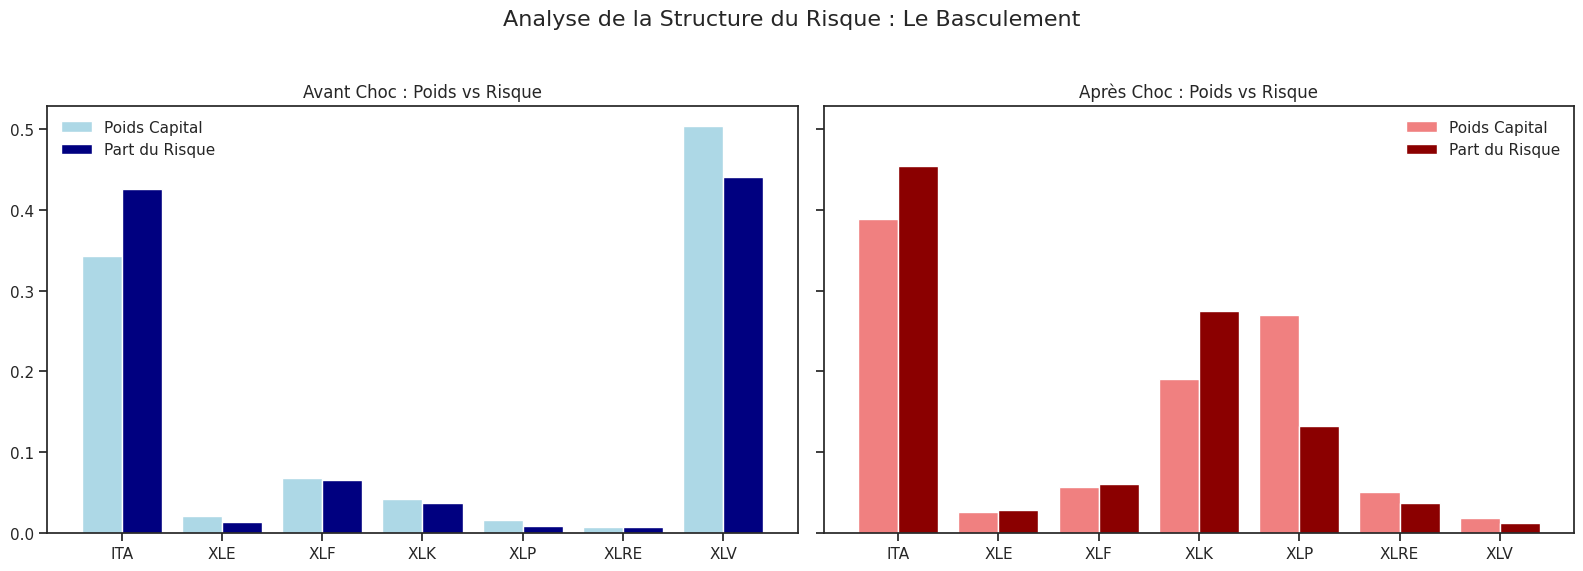

In [ ]:
# Calcul des contributions pour les deux périodes
rc_avant = risk_contribution(best_avant[list(mu_avant.index)].values, cov_avant)
rc_apres = risk_contribution(best_apres[list(mu_apres.index)].values, cov_apres)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Graphique AVANT
ax1.bar(x - 0.2, best_avant[labels], 0.4, label='Poids Capital', color='lightblue')
ax1.bar(x + 0.2, rc_avant, 0.4, label='Part du Risque', color='navy')
ax1.set_title('Avant Choc : Poids vs Risque')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

# Graphique APRÈS
ax2.bar(x - 0.2, best_apres[labels], 0.4, label='Poids Capital', color='lightcoral')
ax2.bar(x + 0.2, rc_apres, 0.4, label='Part du Risque', color='darkred')
ax2.set_title('Après Choc : Poids vs Risque')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

plt.suptitle('Analyse de la Structure du Risque : Le Basculement', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 10. Analyse des Pertes Extrêmes (VaR et CVaR)

#### Explication de la section :

La Value-at-Risk (VaR) et la Conditional Value-at-Risk (CVaR) sont des mesures de risque qui quantifient les pertes potentielles maximales d'un portefeuille sur une période donnée et à un certain niveau de confiance. Cette section calcule ces indicateurs pour les portefeuilles optimaux avant et après le choc, permettant d'évaluer l'exposition aux pertes extrêmes dans les deux environnements de marché.

In [ ]:
def calculate_extreme_risk(returns_df, weights):
    # Rendements historiques du portefeuille
    port_rets = returns_df.dot(weights)

    # VaR Historique 95%
    var_95 = np.percentile(port_rets, 5)

    # Expected Shortfall (Moyenne des rendements inférieurs à la VaR)
    cvar_95 = port_rets[port_rets <= var_95].mean()

    return var_95, cvar_95

# Calcul pour les deux périodes
var_av, cvar_av = calculate_extreme_risk(R_avant, best_avant[labels])
var_ap, cvar_ap = calculate_extreme_risk(R_apres, best_apres[labels])

print(f"--- ANALYSE DE RISQUE (Seuil 95%) ---")
print(f"Avant Choc : VaR = {var_av:.2%}, CVaR = {cvar_av:.2%}")
print(f"Après Choc : VaR = {var_ap:.2%}, CVaR = {cvar_ap:.2%}")

--- ANALYSE DE RISQUE (Seuil 95%) ---
Avant Choc : VaR = -1.24%, CVaR = -1.60%
Après Choc : VaR = -1.59%, CVaR = -3.16%


### 11. Tableau Bilan Synthétique des Stratégies

#### Explication de la section :

Ce tableau récapitulatif consolide tous les indicateurs clés analysés précédemment. Il offre une comparaison directe des performances et du profil de risque des portefeuilles optimaux avant et après le choc de taux, y compris les rendements, volatilités, Ratios de Sharpe, mesures de risque extrême et les allocations sectorielles. C'est un outil synthétique pour tirer des conclusions sur l'impact du choc et les stratégies d'adaptation.

In [ ]:
# Création du dictionnaire de données
summary_data = {
    "Indicateur": [
        "Rendement Annualisé (E[R])",
        "Volatilité Annualisée (σ)",
        "Ratio de Sharpe",
        "Value-at-Risk (VaR 95%)",
        "Expected Shortfall (CVaR 95%)",
        "Poids Secteur Tech (XLK)",
        "Poids Secteur Finance (XLF)"
    ],
    "Avant Choc (Euphorie)": [
        f"{best_avant['Ret']:.2%}",
        f"{best_avant['Vol']:.2%}",
        f"{best_avant['Sharpe']:.2f}",
        f"{var_av:.2%}",
        f"{cvar_av:.2%}",
        f"{best_avant['XLK']:.2%}",
        f"{best_avant['XLF']:.2%}"
    ],
    "Après Choc (Réalité FED)": [
        f"{best_apres['Ret']:.2%}",
        f"{best_apres['Vol']:.2%}",
        f"{best_apres['Sharpe']:.2f}",
        f"{var_ap:.2%}",
        f"{cvar_ap:.2%}",
        f"{best_apres['XLK']:.2%}",
        f"{best_apres['XLF']:.2%}"
    ]
}

# Transformation en DataFrame pour un affichage propre
df_bilan = pd.DataFrame(summary_data)

# Affichage avec style
print("--- TABLEAU RÉCAPITULATIF DES STRATÉGIES ---")
display(df_bilan) # Utilise display pour un rendu propre dans le notebook

--- TABLEAU RÉCAPITULATIF DES STRATÉGIES ---


,Indicateur,Avant Choc (Euphorie),Après Choc (Réalité FED)
0,Rendement Annualisé (E[R]),0.79%,48.20%
1,Volatilité Annualisée (σ),12.27%,23.28%
2,Ratio de Sharpe,-0.30,1.88
3,Value-at-Risk (VaR 95%),-1.24%,-1.59%
4,Expected Shortfall (CVaR 95%),-1.60%,-3.16%
5,Poids Secteur Tech (XLK),4.23%,19.07%
6,Poids Secteur Finance (XLF),6.77%,5.71%
